In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 15 02:35:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Project Background
In this project, we delve into a dataset comprised of 10,876 tweets, each a potential window into real-world events, particularly disasters. The dataset is a rich tapestry of text, occasionally supplemented with keywords and location data, although these fields can be blank. Each tweet is tagged with a binary label, indicating whether it pertains to an actual disaster (1) or not (0). The dataset is partitioned into 7,613 entries for training and 3,263 for testing, setting the stage for a comprehensive analysis.

The goal is to harness the power of machine learning and natural language processing to build models capable of accurately classifying these tweets. This binary classification task is not just an academic exercise but a practical tool in real-time disaster response and information dissemination. By training models on the nuanced language of tweets, we aim to achieve a high degree of accuracy in distinguishing between tweets related to real disasters and those that are not, thereby demonstrating the potential of leveraging social media data in critical, fast-paced scenarios.

## 2) Import Python Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns# for data visualization
from sklearn.model_selection import train_test_split  # for splitting data into training and testing sets
from tensorflow.keras.preprocessing.text import Tokenizer # for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences # for text padding
from tensorflow.keras.models import Sequential # for building neural networks
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout # for building neural networks
from tensorflow.keras.optimizers import Adam #
from tensorflow.keras.callbacks import EarlyStopping
import os

In [ ]:
import os
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain

## 3) Import Data

In [ ]:
df_train =pd.read_csv('/content/drive/MyDrive/kaggle_data/Natural Language Processing with Disaster Tweets/train.csv')
df_test =pd.read_csv('/content/drive/MyDrive/kaggle_data/Natural Language Processing with Disaster Tweets/test.csv')

## 4) Explarotary Data Analysis

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Upon reviewing the structure of our data files, it's clear that our training dataset contains a 'Target' column, which denotes whether each tweet is related to an actual disaster (1) or not (0). Additionally, we have a test dataset designed to evaluate the performance of our models after they classify the tweets as disaster-related or not.

In the upcoming stages, our aim is to thoroughly examine all available data, including both the training and testing datasets, as part of our data exploration process. To achieve this, we will merge these two datasets into a single unified dataset. This consolidation allows us to analyze the entire dataset as a whole, helping us gain a comprehensive understanding of its characteristics, patterns, and potential insights. By doing so, we ensure that no valuable information is overlooked, which is crucial for informed decision-making and subsequent analysis tasks.

In the upcoming stages, our aim is to thoroughly examine all available data, including both the training and testing datasets, as part of our data exploration process. To achieve this, we will merge these two datasets into a single unified dataset. This consolidation allows us to analyze the entire dataset as a whole, helping us gain a comprehensive understanding of its characteristics, patterns, and potential insights. By doing so, we ensure that no valuable information is overlooked, which is crucial for informed decision-making and subsequent analysis tasks.

In [ ]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The 'keyword' and 'location' columns in our dataset contain missing values and appear to offer limited value for our predictive task, which primarily relies on the tweet text. Therefore, to simplify our analysis and focus on the most crucial aspect, we will remove these two columns. This approach ensures our model concentrates solely on the text content, the key element in determining if a tweet pertains to an actual disaster.

In [ ]:
df_train = df_train.drop(columns=['keyword', 'location'])
df_test = df_test.drop(columns=['keyword', 'location'])

### c) Data Exploration
A closer look at the categories distribution

In [ ]:
df_train['target'].value_counts(normalize=True) * 100

0    57.034021
1    42.965979
Name: target, dtype: float64

### d) Dtat Visualization

In the exploration of our train dataset consisting of 7,613  tweets, we delve into a rich tapestry of information captured primarily in two key columns: 'Tweet ID' and 'Tweet Text.' Each tweet is categorically labeled as related to a real disaster (1) or not (0), offering a binary yet profound perspective on the nature of the content. Our objective is to uncover meaningful patterns, trends, and insights within this vast and intricate dataset through data visualization. This approach will not only highlight the distinguishing characteristics of disaster-related and non-disaster-related tweets but also provide a comprehensive understanding of the overarching themes and nuances present in the collective dataset of tweets.

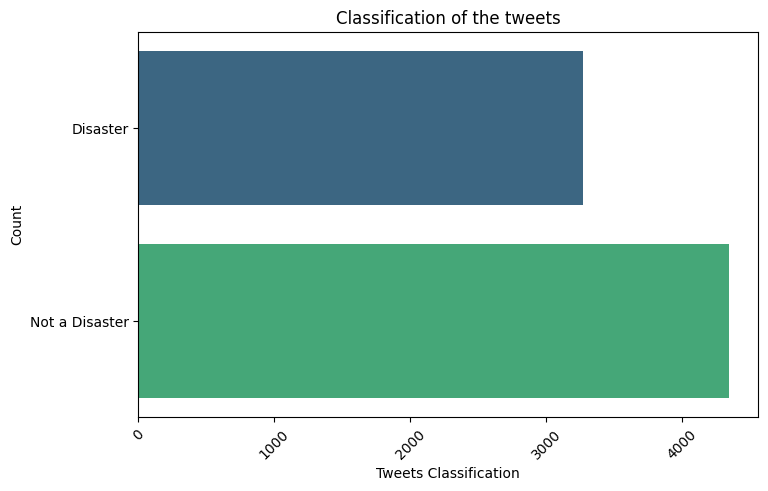

In [ ]:
# Bar chart of category counts
plt.figure(figsize=(8, 5))
sns.countplot(y=df_train['target'].map({1: 'Disaster', 0: 'Not a Disaster'}), palette='viridis')
plt.xlabel('Tweets Classification')
plt.ylabel('Count')
plt.title('Classification of the tweets')
plt.xticks(rotation=45)
plt.show()

#### Word count
Following our examination of the categories, we will now delve into the text content itself. Our objective is to understand the distribution of word counts in each text and identify any outliers. To achieve this, we will introduce a new column in the dataset labeled 'Word_Count'.

In [ ]:
# Add a new column 'Word Count' to store the word counts
df_train['Word Count'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Display the DataFrame with the word counts
df_train.head()

,id,text,target,Word Count
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,8
4,7,Just got sent this photo from Ruby #Alaska as ...,1,16


In [ ]:
df_train.describe()

,id,target,Word Count
count,7613.000000,7613.00000,7613.000000
mean,5441.934848,0.42966,14.903586
std,3137.116090,0.49506,5.732604
min,1.000000,0.00000,1.000000
25%,2734.000000,0.00000,11.000000
50%,5408.000000,0.00000,15.000000
75%,8146.000000,1.00000,19.000000
max,10873.000000,1.00000,31.000000


In [ ]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


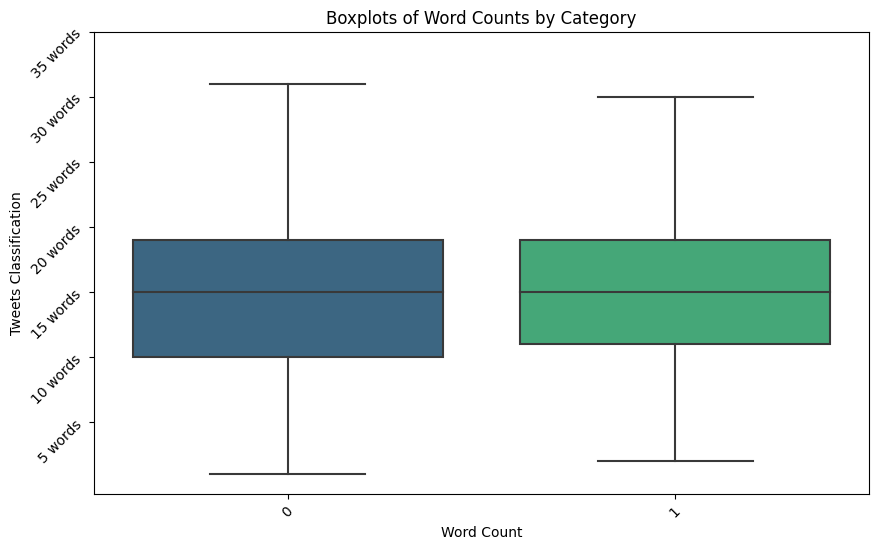

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='Word Count', data=df_train, palette='viridis')
plt.ylabel('Tweets Classification')
plt.xlabel('Word Count')
plt.title('Boxplots of Word Counts by Category')
plt.xticks(rotation=45)

tick_positions = [5, 10, 15, 20, 25, 30, 35]  # Adjust these values as needed
tick_labels = ['5 words', '10 words', '15 words', '20 words', '25 words', '30 words', '35 words']  # Adjust these labels as needed words',  '30 words',  '50 words', '100 words', '150 words']  # Adjust these labels as needed]  # Adjust these labels
plt.yticks(tick_positions, tick_labels, rotation=45)


plt.show()

The boxplots reveal that the majority of articles contain fewer than 20 words.

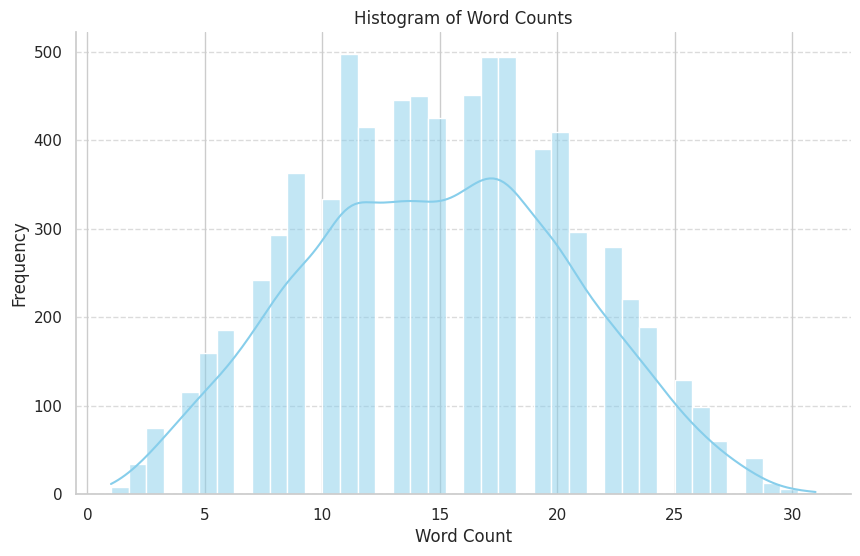

In [ ]:
# Set the style
sns.set(style="whitegrid")

# Create the histogram with Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Word Count', bins=40, color='skyblue', kde=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 5) Deep Learning LSTM Model

In [ ]:
X_train = df_train.text
y_train = df_train.target
X_test = df_test.text
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# To prepare text data for machine learning models, we first tokenize the text, converting it into sequences of numerical tokens, each representing a specific word. Then, we apply padding to these sequences to ensure they all have the same length, facilitating consistent input size for training neural networks, random_state=42)

To prepare text data for machine learning models, we first tokenize the text, converting it into sequences of numerical tokens, each representing a specific word. Then, we apply padding to these sequences to ensure they all have the same length, facilitating consistent input size for training neural networks. This process is essential for models that rely on the sequential nature of the data, such as those used in text classification and sentiment analysis.

In [ ]:
# Assuming the Tokenizer is initialized with a limit of 5000 words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)



# Adjust the max_length to 31 as per your dataset
max_length = 31
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:
# ## 6) Deep Learning LSTM Model

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=1)
model.fit(X_train_pad, y_train, batch_size=16, epochs=10, validation_data=(X_val_pad, y_val))

Epoch 1/10
429/429 [==============================] - 14s 24ms/step - loss: 0.5060 - accuracy: 0.7524 - val_loss: 0.4585 - val_accuracy: 0.8045
Epoch 2/10
429/429 [==============================] - 3s 8ms/step - loss: 0.3383 - accuracy: 0.8621 - val_loss: 0.4890 - val_accuracy: 0.7756
Epoch 3/10
429/429 [==============================] - 3s 6ms/step - loss: 0.2680 - accuracy: 0.8940 - val_loss: 0.5341 - val_accuracy: 0.7743
Epoch 4/10
429/429 [==============================] - 2s 5ms/step - loss: 0.1995 - accuracy: 0.9193 - val_loss: 0.6511 - val_accuracy: 0.7402
Epoch 5/10
429/429 [==============================] - 2s 6ms/step - loss: 0.1510 - accuracy: 0.9404 - val_loss: 0.8582 - val_accuracy: 0.7454
Epoch 6/10
429/429 [==============================] - 2s 5ms/step - loss: 0.1116 - accuracy: 0.9552 - val_loss: 0.9231 - val_accuracy: 0.7638
Epoch 7/10
429/429 [==============================] - 3s 6ms/step - loss: 0.0875 - accuracy: 0.9639 - val_loss: 0.9469 - val_accuracy: 0.7441
Epoc

The training results indicate that ther model is overfitting, as evidenced by a high accuracy on the training set (97.42%) but significantly lower accuracy on the validation set (76.12%). We will creat a second model where we will use the dropout technics and early stopping

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model_2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model_2.fit(X_train_pad, y_train, batch_size=16, epochs=10, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/10
429/429 [==============================] - 57s 134ms/step - loss: 0.4293 - accuracy: 0.8091 - val_loss: 0.4653 - val_accuracy: 0.7900
Epoch 2/10
429/429 [==============================] - 50s 116ms/step - loss: 0.3197 - accuracy: 0.8724 - val_loss: 0.5301 - val_accuracy: 0.7874


the acccuracy of the training set is 87.24% and the validation set is 78.74%, with the dropout and the early stopping the variance decreasd, however, the accuracy is still low. we will try the L2 regularization model to reduce the variance

In [ ]:
model_3 = Sequential()
model_3.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model_3.add(LSTM(64))

In [ ]:
from tensorflow.keras.regularizers import l2

# Add L2 regularization to the Dense layer
model_3.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

In [ ]:
# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model

# Early stopping callback

model_3.fit(X_train_pad, y_train, batch_size=16, epochs=10, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

429/429 [==============================] - 12s 23ms/step - loss: 0.5172 - accuracy: 0.7578 - val_loss: 0.4624 - val_accuracy: 0.8018
Epoch 2/10
429/429 [==============================] - 3s 7ms/step - loss: 0.3565 - accuracy: 0.8580 - val_loss: 0.4854 - val_accuracy: 0.7927


the acccuracy of the training set is 85.80% and the validation set is 79.274%, the L2 regulization increased the variation by slightly decreasing the accuracy of the training set and sligghtly increassing the accuracy of the validation set.

In [ ]:
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int)
df_test['target'] = predicted_labels
submission_df = df_test[['id', 'target']]
submission_df.to_csv('submission.csv', index=False)


the accuracy of the test set of this model is 76.1%

In [ ]:
predictions_2 = model_2.predict(X_test_pad)
predicted_labels_2 = (predictions_2 > 0.5).astype(int)
df_test['target'] = predicted_labels_2
submission_df = df_test[['id', 'target']]
submission_df.to_csv('submission_2.csv', index=False)

102/102 [==============================] - 1s 10ms/step


the accuracy of the test set of this model is 77.72%

In [ ]:
predictions_3 = model_3.predict(X_test_pad)
predicted_labels_3 = (predictions_3 > 0.5).astype(int)
df_test['target'] = predicted_labels_3
submission_df = df_test[['id', 'target']]
submission_df.to_csv('submission_3.csv', index=False)

102/102 [==============================] - 1s 2ms/step


the accuracy of the test set of this model is 77.61%

the Accuracy of the test set is low therefore we will try another learning model **ktrain**

## 5) Deep Learning ktrain

The code imports the NLTK library in Python and downloads a collection of 'stopwords'—commonly used words typically omitted in language processing tasks.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This code imports the stopwords set from NLTK's corpus module and Python's re and string modules, for natural language processing, regular expressions, and string operations respectively.

In [ ]:
from nltk.corpus import stopwords
import re
import string

This code processes a pandas DataFrame df_train by:

1- Converting the 'text' column to lowercase.

2- Removing punctuation from the 'text' column using a regular expression.

3- Removing all numbers from the 'text' column using a regular expression.

In [ ]:
df_train['text'] = df_train['text'].str.lower()
df_train['text'] = df_train['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_train['text'] = df_train['text'].apply(lambda x: re.sub('[0-9]', '', x))

The code defines a function to remove English stopwords from text and applies it to the 'text' column of df_train. It also removes extra spaces from the text.

In [ ]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df_train['text'] = df_train['text'].apply(lambda x: remove_stopwords(x))
df_train['text'] = df_train['text'].apply(lambda x: re.sub(' +', ' ', x))

This code imports the WordNetLemmatizer, word_tokenize function, and wordnet corpus from NLTK, and downloads the 'punkt', 'wordnet', 'omw-1.4', and 'averaged_perceptron_tagger' resources for text tokenization, lemmatization, and part-of-speech tagging.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

The code defines a lemmatization process for sentences:

**1- get_pos:** A function to determine the part-of-speech tag for a given word, used for more accurate lemmatization.

**2- lemmatization:** A function that tokenizes a sentence, then lemmatizes each word based on its part-of-speech, and finally reconstructs the sentence.

In [ ]:
wnl = WordNetLemmatizer()

def get_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].lower()
  tag_dict = {"j": wordnet.ADJ,
              "n": wordnet.NOUN,
              "v": wordnet.VERB,
              "r": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def lemmatization(sentence):
  word_tokens = word_tokenize(sentence)
  lemmatized_sentence = ' '.join([wnl.lemmatize(word, get_pos(word)) for word in word_tokens])
  return lemmatized_sentence

This line of code applies the lemmatization function to each entry in the 'text' column of the df_train DataFrame, effectively processing the text data by lemmatizing it.

In [ ]:
df_train['text'] = df_train['text'].apply(lambda x: lemmatization(x))

This code loops through the first five entries in the 'text' column of the df_train DataFrame and prints each sentence with a preceding number (1 to 5).

In [ ]:
for i, sentence in enumerate(df_train['text'].head(5)):
  print(f'{i+1}. {sentence}')

1. deed reason earthquake may allah forgive u
2. forest fire near la ronge sask canada
3. resident ask shelter place notify officer evacuation shelter place order expect
4. people receive wildfire evacuation order california
5. get sent photo ruby alaska smoke wildfire pours school


This code uses ktrain, a lightweight wrapper for the deep learning library Keras, to preprocess text data from a DataFrame for training a text classification model

In [ ]:
train, val, preprocess = ktrain.text.texts_from_df(
    df_train,
    "text",
    label_columns=["target"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=2,
    preprocess_mode="distilbert",
    verbose=1,
    random_state=10
)

['not_target', 'target']
      not_target  target
5362         1.0     0.0
5969         1.0     0.0
3779         0.0     1.0
3684         1.0     0.0
5190         1.0     0.0
['not_target', 'target']
      not_target  target
6524         1.0     0.0
701          1.0     0.0
3119         0.0     1.0
4204         1.0     0.0
1651         1.0     0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 17


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 17


In [ ]:
 len(train) + len(val)

7613

This code initializes a text classification model using ktrain's preprocessing setup and creates a learner object with the model, training and validation datasets, using a batch size of 16.

In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [ ]:
learner.lr_find(max_epochs=10)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
428/428 [==============================] - 138s 292ms/step - loss: 0.6952 - accuracy: 0.4965
Epoch 2/10
428/428 [==============================] - 126s 296ms/step - loss: 0.5525 - accuracy: 0.7731
Epoch 3/10
428/428 [==============================] - 126s 294ms/step - loss: 0.4218 - accuracy: 0.8215
Epoch 4/10
428/428 [==============================] - 126s 293ms/step - loss: 0.3920 - accuracy: 0.8402
Epoch 5/10
428/428 [==============================] - 125s 292ms/step - loss: 0.5568 - accuracy: 0.6966
Epoch 6/10
428/428 [==============================] - 125s 292ms/step - loss: 0.6933 - accuracy: 0.5666
Epoch 7/10
428/428 [==============================] - 125s 292ms/step - loss: 0.6873 - accuracy: 0.5721
Epoch 8/10
428/428 [==============================] - 77s 178ms/step - loss: 21.7180 - accuracy: 0.5614


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot 

This line of code will generate and display a plot of the learning rate finder results, helping to identify an optimal learning rate for training the model in ktrain.

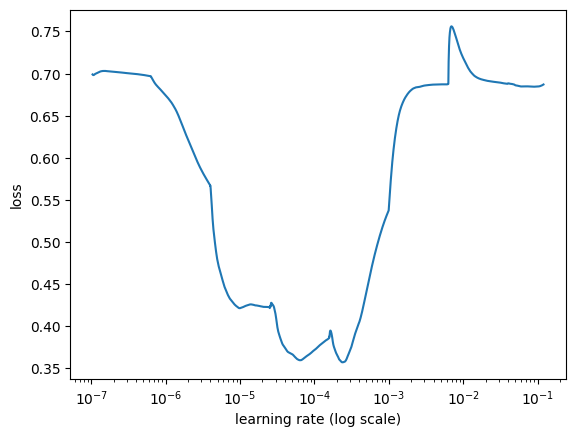

In [ ]:
learner.lr_plot()

This line uses ktrain's autofit method to train the model with an initial learning rate of
1
×
10e-4
 , saving checkpoints, for up to 10 epochs, and includes early stopping to prevent overfitting.

In [ ]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
429/429 [==============================] - 139s 302ms/step - loss: 0.5188 - accuracy: 0.7665 - val_loss: 0.4695 - val_accuracy: 0.7992
Epoch 2/10
429/429 [==============================] - 127s 296ms/step - loss: 0.3786 - accuracy: 0.8508 - val_loss: 0.4405 - val_accuracy: 0.8097
Epoch 3/10
429/429 [==============================] - 127s 296ms/step - loss: 0.3088 - accuracy: 0.8831 - val_loss: 0.4905 - val_accuracy: 0.8031
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


The code initializes a ktrain predictor object with the trained model from learner and the preprocessing setup preprocess, for making predictions on new data.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

This line of code uses ktrain to evaluate the trained model on the validation dataset (val), printing a detailed performance report.

In [ ]:
validation = learner.validate(val_data=val, print_report=True)

24/24 [==============================] - 2s 31ms/step
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       407
           1       0.83      0.74      0.78       355

    accuracy                           0.81       762
   macro avg       0.81      0.81      0.81       762
weighted avg       0.81      0.81      0.81       762



This code processes the 'text' column in the df_test DataFrame by converting it to lowercase, removing punctuation, and then removing all numbers.

In [ ]:
df_test['text'] = df_test['text'].str.lower()
df_test['text'] = df_test['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_test['text'] = df_test['text'].apply(lambda x: re.sub('[0-9]', '', x))

This code applies two operations on the 'text' column of df_test: first, it removes stopwords, and then it eliminates extra spaces, leaving only single spaces between words.

In [ ]:
df_test['text'] = df_test['text'].apply(lambda x: remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x: re.sub(' +', ' ', x))

This line applies the lemmatization function to each entry in the 'text' column of the df_test DataFrame, processing the text data by lemmatizing it.

In [ ]:
df_test['text'] = df_test['text'].apply(lambda x: lemmatization(x))

This code uses the preprocess object to preprocess the text data in the 'text' column of df_test, converting it into a format suitable for making predictions with the trained model. The text data is converted to a list before processing.

In [ ]:
test_data = preprocess.preprocess_test(df_test['text'].tolist())

preprocessing test...
language: en
test sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 17


This line uses the predictor object from ktrain to make predictions on the text data in the 'text' column of df_test, after converting it into a list.

In [ ]:
predictions_ktrain = predictor.predict(df_test['text'].tolist())

In [ ]:
predicted_labels_ktrain = list(predictions_ktrain)

# Replace 'target' with 1 and 'not target' with 0
predicted_labels_ktrain = [1 if label == 'target' else 0 for label in predicted_labels_ktrain]
df_test['target'] = predicted_labels_ktrain
submission_df = df_test[['id', 'target']]
submission_df.to_csv('submission_ktrain.csv', index=False)

This model reached a better variance and leww bis as the accuracy of the training and the validation sets were respectively 88.31% and 80.31%. and the result of the tests were 80.06.

## **Conclusion**

The best model was the **ktain** as it minimize both the bias and the variance